## 1. Environment Setup and Configuration

In [8]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.special import logit, expit

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import gpjax as gpx
import optax as ox
import jax.random as jr
from jax import config
from jax_decision_making.posterior_handler import PosteriorHandler

EMBEDDINGS_DIR = "embs"
KMEANS_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "kMeans_embeddings.csv")
MEAN_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "mean_embeddings.csv")
SAMPLED_EMBEDDINGS_PATH = os.path.join(EMBEDDINGS_DIR, "samples_embeddings.csv")

USE_KMEANS_DATA = False


REDUCE_EMBEDDING_DIMS = False
PCA_COMPONENTS = 50

## 2. Data Loading and Preprocessing

In [ ]:
def parse_embedding_string(embedding_str: str) -> np.ndarray:
    """Converts a string representation of a NumPy array back into an array."""
    cleaned_str = embedding_str.strip('[]').strip()
    numbers = re.split(r'\s+', cleaned_str)
    return np.array([float(n) for n in numbers])

df_mean = pl.read_csv(MEAN_EMBEDDINGS_PATH).with_columns(
    pl.col('mean_embedding').map_elements(parse_embedding_string, return_dtype=pl.Object)
)

print(f"Loaded {len(df_mean)} mean embeddings.")

if USE_KMEANS_DATA:
    print(f"Loading K-Means representative embeddings from {KMEANS_EMBEDDINGS_PATH}")
    df_representatives = pl.read_csv(KMEANS_EMBEDDINGS_PATH).with_columns(
        pl.col('embedding').map_elements(parse_embedding_string, return_dtype=pl.Object)
    )
else:
    print(f"Loading randomly sampled representative embeddings from {SAMPLED_EMBEDDINGS_PATH}")
    df_representatives = pl.read_csv(SAMPLED_EMBEDDINGS_PATH).with_columns(
        pl.col('embedding').map_elements(parse_embedding_string, return_dtype=pl.Object)
    )

print(f"Loaded {len(df_representatives)} representative embeddings for modeling.")

Loaded 32 mean embeddings.
Loading randomly sampled representative embeddings from embs/samples_embeddings.csv
Loaded 640 representative embeddings for modeling.


## 3. Exploratory Data Analysis 

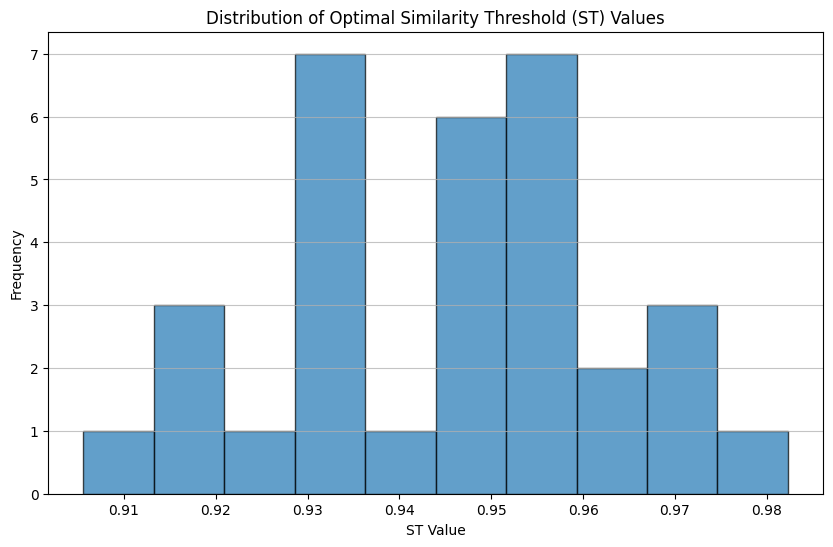

In [ ]:
st_values = df_mean['st'].to_numpy()

plt.figure(figsize=(10, 6))
plt.hist(st_values, bins=10, alpha=0.7, edgecolor='black')
plt.title('Distribution of Optimal Similarity Threshold (ST) Values')
plt.xlabel('ST Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Total variance explained by PC1 & PC2: 23.87%


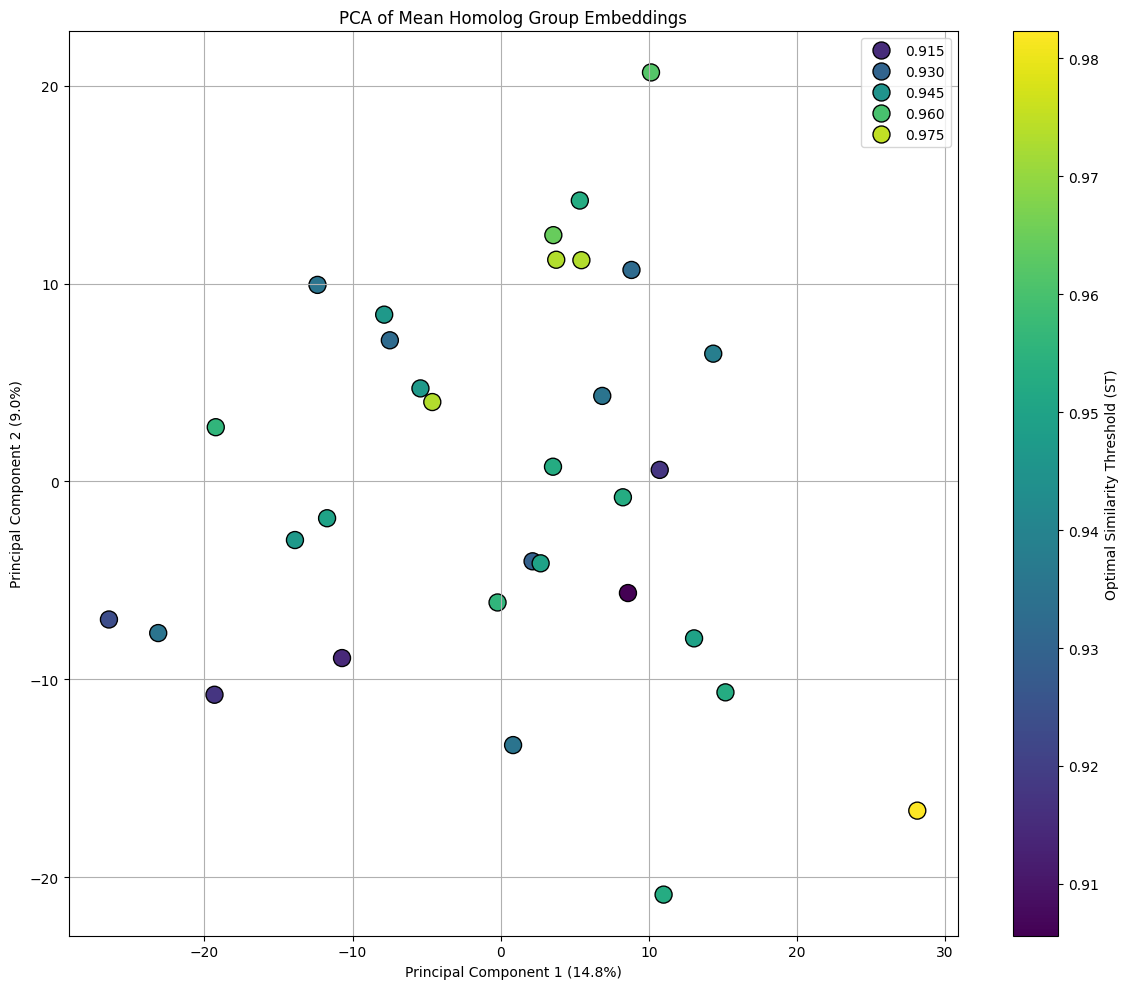

In [ ]:
X_mean = np.vstack(df_mean['mean_embedding'].to_numpy())
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_mean)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_normalized)

explained_variance = pca.explained_variance_ratio_
print(f"Total variance explained by PC1 & PC2: {np.sum(explained_variance):.2%}")

plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df_mean['st'].to_numpy(),
    palette='viridis',
    s=150,
    edgecolor='black'
)

plt.title('PCA of Mean Homolog Group Embeddings')
plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.1%})')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.1%})')
plt.grid(True)

norm = plt.Normalize(df_mean['st'].min(), df_mean['st'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
cbar = plt.colorbar(sm, ax=scatter.axes)
cbar.set_label('Optimal Similarity Threshold (ST)')

plt.tight_layout()
plt.show()

## 4. Gaussian Process Model Validation with Leave-One-Group-Out CV

In [7]:
# assess the model's ability to generalize to unseen homolog groups,
# we use Leave-One-Group-Out cv. This method trains the model on all but one group
# and tests it on the held-out group. This simulates a "real-world"
# scenario where the model must predict an optimal ST for new protein families.

config.update("jax_enable_x64", True)
key = jr.key(123) 

X = np.vstack(df_representatives['embedding'].to_list())
y = df_representatives['st'].to_numpy()
groups = df_representatives['homolog_group'].to_numpy()

# Logit-transform the target variable
epsilon = 1e-7
y_clipped = np.clip(y, epsilon, 1 - epsilon)
y_transformed = logit(y_clipped)

mean = gpx.mean_functions.Zero()
kernel = gpx.kernels.RBF()
prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
likelihood_builder = lambda n: gpx.likelihoods.Gaussian(num_datapoints=n)
posterior_handler = PosteriorHandler(
    prior,
    likelihood_builder=likelihood_builder,
    optimization_objective=lambda p, d: -gpx.objectives.conjugate_mll(p, d),
    optimizer=ox.adam(learning_rate=0.01),
    num_optimization_iters=200,
)

logo = LeaveOneGroupOut()
gpjax_logo_results = []
all_true_st = []
all_pred_st = []
all_pred_std_transformed = []
all_true_st_transformed = []
all_pred_st_transformed = []

print("Starting GPJax Leave-One-Group-Out Cross-Validation...")
if REDUCE_EMBEDDING_DIMS:
    print(f"Dimensionality reduction is ENABLED. Using {PCA_COMPONENTS} components.")

for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_transformed, groups)):
    key, fold_key = jr.split(key) 
    
    X_train_fold, X_test_fold = X[train_idx], X[test_idx]
    y_train, y_test = y_transformed[train_idx], y_transformed[test_idx]
    held_out_group = groups[test_idx][0]
    
    if REDUCE_EMBEDDING_DIMS:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        
        pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
        X_train_final = pca.fit_transform(X_train_scaled)
        
        X_test_scaled = scaler.transform(X_test_fold)
        X_test_final = pca.transform(X_test_scaled)
    else:
        X_train_final = X_train_fold
        X_test_final = X_test_fold
        
    train_data = gpx.Dataset(X=X_train_final, y=y_train.reshape(-1, 1))

    initial_likelihood = likelihood_builder(train_data.n)
    initial_posterior = prior * initial_likelihood
    
    posterior = posterior_handler.update_posterior(
        dataset=train_data, previous_posterior=initial_posterior, optimize=True, key=fold_key
    )

    latent_dist = posterior.predict(X_test_final, train_data=train_data)
    predictive_dist = posterior.likelihood(latent_dist)
    y_pred_transformed = predictive_dist.mean()
    y_pred_std_transformed = predictive_dist.stddev()

    # Invert the logit transform to get results on the original [0, 1] scale
    y_pred_original = expit(y_pred_transformed)
    y_test_original = expit(y_test)
    
    fold_mse = mean_squared_error(y_test_original, y_pred_original)
    
    gpjax_logo_results.append({
        'held_out_group': held_out_group,
        'error_sq': fold_mse
    })
    
    all_true_st.append(y_test_original)
    all_pred_st.append(y_pred_original)
    all_pred_std_transformed.append(y_pred_std_transformed)
    all_true_st_transformed.append(y_test)
    all_pred_st_transformed.append(y_pred_transformed)

    print(f"  - Fold {fold+1}/{logo.get_n_splits(groups=groups)} | Tested on group: {held_out_group:<65} | MSE: {fold_mse:.6f}")

results_df_gpjax_errors = pl.DataFrame(gpjax_logo_results)
average_mse_gpjax = results_df_gpjax_errors['error_sq'].mean()

print(f"\nLOGO-CV Complete. Average MSE for the GPJax Model across all folds: {average_mse_gpjax:.6f}")

true_st_flat = np.concatenate(all_true_st)
pred_st_flat = np.concatenate(all_pred_st)
pred_std_transformed_flat = np.concatenate(all_pred_std_transformed)
true_st_transformed_flat = np.concatenate(all_true_st_transformed)
pred_st_transformed_flat = np.concatenate(all_pred_st_transformed)

results_df = pl.DataFrame({
    'true_st': true_st_flat,
    'predicted_st': pred_st_flat,
    'true_st_transformed': true_st_transformed_flat,
    'predicted_st_transformed': pred_st_transformed_flat,
    'prediction_std_transformed': pred_std_transformed_flat
})

Starting GPJax Leave-One-Group-Out Cross-Validation...
  - Fold 1/32 | Tested on group: 1-4-dihydroxy-2-naphthoate_octaprenyltransferase                  | MSE: 0.000208
  - Fold 2/32 | Tested on group: 2-amino-4-hydroxy-6-hydroxymethyldihydropteridine                 | MSE: 0.000677
  - Fold 3/32 | Tested on group: 2-oxoglutarate_dehydrogenase_E1                                   | MSE: 0.000024
  - Fold 4/32 | Tested on group: 2-succinyl-5-enolpyruvyl-6-hydroxy-3-cyclohexene-1-carboxylic-acid_synthase | MSE: 0.001125
  - Fold 5/32 | Tested on group: 3-methyl-2-oxobutanoate_hydroxymethyltransferase                  | MSE: 0.000112
  - Fold 6/32 | Tested on group: 4-diphosphocytidyl-2-C-methyl-D-erythritol_kinase                 | MSE: 0.000108
  - Fold 7/32 | Tested on group: 4-hydroxy-3-methylbut-2-en-1-yl_diphosphate_synthase              | MSE: 0.000075
  - Fold 8/32 | Tested on group: 4-hydroxy-3-methylbut-2-enyl_diphosphate_reductase                | MSE: 0.000273
  - Fold 9/32 |

## 5. Baseline Model Comparison

### 5.1 Linear Regression with PCA Baseline

In [9]:
#A linear regression model serves as the first baseline.
# It tests whether a simple linear relationship, either in the full-dimensional space or a 
# reduced-dimensionality space , can capture the connection between 
# embeddings and ST values. 

logo = LeaveOneGroupOut()
lm_results = []

print("Starting Leave-One-Group-Out Cross-Validation for the Linear Model...")
if REDUCE_EMBEDDING_DIMS:
    print(f"Dimensionality reduction is ENABLED. Using {PCA_COMPONENTS} components.")



for i, train_idx, test_idx in enumerate(logo.split(X, y_transformed, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y_transformed[train_idx], y_transformed[test_idx]
    held_out_group = groups[test_idx][0]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    if REDUCE_EMBEDDING_DIMS:
        pca = PCA(n_components=PCA_COMPONENTS, random_state=42)
        X_train_final = pca.fit_transform(X_train_scaled)
        X_test_final = pca.transform(X_test_scaled)
    else:
        X_train_final = X_train_scaled
        X_test_final = X_test_scaled

    linear_model = LinearRegression()
    linear_model.fit(X_train_final, y_train)
    
    y_pred_transformed = linear_model.predict(X_test_final)

    y_pred_original = expit(y_pred_transformed)
    y_test_original = expit(y_test)
    
    fold_mse = mean_squared_error(y_test_original, y_pred_original)
    lm_results.append({
        'held_out_group': held_out_group,
        'error_sq': fold_mse
    })
    print(f"Fold {i+1}/{logo.get_n_splits(groups=groups)} | ", end="")
    # print(f"  - Tested on group: {held_out_group:<65} | MSE: {fold_mse:.6f}")

results_df_lm = pl.DataFrame(lm_results)
average_mse_lm = results_df_lm['error_sq'].mean()

print(f"\nLOGO-CV Complete. Average MSE for the Linear Model across all folds: {average_mse_lm:.6f}")

Starting Leave-One-Group-Out Cross-Validation for the Linear Model...
  - Tested on group: 1-4-dihydroxy-2-naphthoate_octaprenyltransferase                  | MSE: 0.000477
  - Tested on group: 2-amino-4-hydroxy-6-hydroxymethyldihydropteridine                 | MSE: 0.001091
  - Tested on group: 2-oxoglutarate_dehydrogenase_E1                                   | MSE: 0.000066
  - Tested on group: 2-succinyl-5-enolpyruvyl-6-hydroxy-3-cyclohexene-1-carboxylic-acid_synthase | MSE: 0.001516
  - Tested on group: 3-methyl-2-oxobutanoate_hydroxymethyltransferase                  | MSE: 0.000047
  - Tested on group: 4-diphosphocytidyl-2-C-methyl-D-erythritol_kinase                 | MSE: 0.000264
  - Tested on group: 4-hydroxy-3-methylbut-2-en-1-yl_diphosphate_synthase              | MSE: 0.000072
  - Tested on group: 4-hydroxy-3-methylbut-2-enyl_diphosphate_reductase                | MSE: 0.000063
  - Tested on group: 4-hydroxy-tetrahydrodipicolinate_reductase                        | MSE: 0.

### 5.2 Simple Mean Baseline

In [10]:
# The simplest baseline using the mean of all other groups' ST values. This provides a
# reference MSE to evaluate the if more complex models capture anything.
# This baseline model's prediction is based solely on the target variable (y) of the training set. 


logo = LeaveOneGroupOut()
baseline_results = []

print("Starting Leave-One-Group-Out Cross-Validation for the simple mean baseline...")

for train_idx, test_idx in logo.split(X, y, groups):
    y_train = y[train_idx]
    y_test = y[test_idx]
    held_out_group = groups[test_idx][0]

    mean_st_prediction = np.mean(y_train)

    y_pred = np.full_like(y_test, fill_value=mean_st_prediction)

    fold_mse = mean_squared_error(y_test, y_pred)
    
    baseline_results.append({
        'held_out_group': held_out_group,
        'error_sq': fold_mse
    })
    
    print(f"  - Tested on group: {held_out_group:<65} | MSE: {fold_mse:.6f}")

# Calculate the overall average MSE using a Polars DataFrame.
results_df_baseline = pl.DataFrame(baseline_results)
average_mse_baseline = results_df_baseline['error_sq'].mean()

print(f"\nLOGO-CV Complete. Average MSE for the simple mean baseline across all folds: {average_mse_baseline:.6f}")

Starting Leave-One-Group-Out Cross-Validation for the simple mean baseline...
  - Tested on group: 1-4-dihydroxy-2-naphthoate_octaprenyltransferase                  | MSE: 0.000003
  - Tested on group: 2-amino-4-hydroxy-6-hydroxymethyldihydropteridine                 | MSE: 0.000510
  - Tested on group: 2-oxoglutarate_dehydrogenase_E1                                   | MSE: 0.000062
  - Tested on group: 2-succinyl-5-enolpyruvyl-6-hydroxy-3-cyclohexene-1-carboxylic-acid_synthase | MSE: 0.001002
  - Tested on group: 3-methyl-2-oxobutanoate_hydroxymethyltransferase                  | MSE: 0.000402
  - Tested on group: 4-diphosphocytidyl-2-C-methyl-D-erythritol_kinase                 | MSE: 0.000108
  - Tested on group: 4-hydroxy-3-methylbut-2-en-1-yl_diphosphate_synthase              | MSE: 0.000053
  - Tested on group: 4-hydroxy-3-methylbut-2-enyl_diphosphate_reductase                | MSE: 0.000822
  - Tested on group: 4-hydroxy-tetrahydrodipicolinate_reductase                        |

## 6. GP Model Performance Visualization

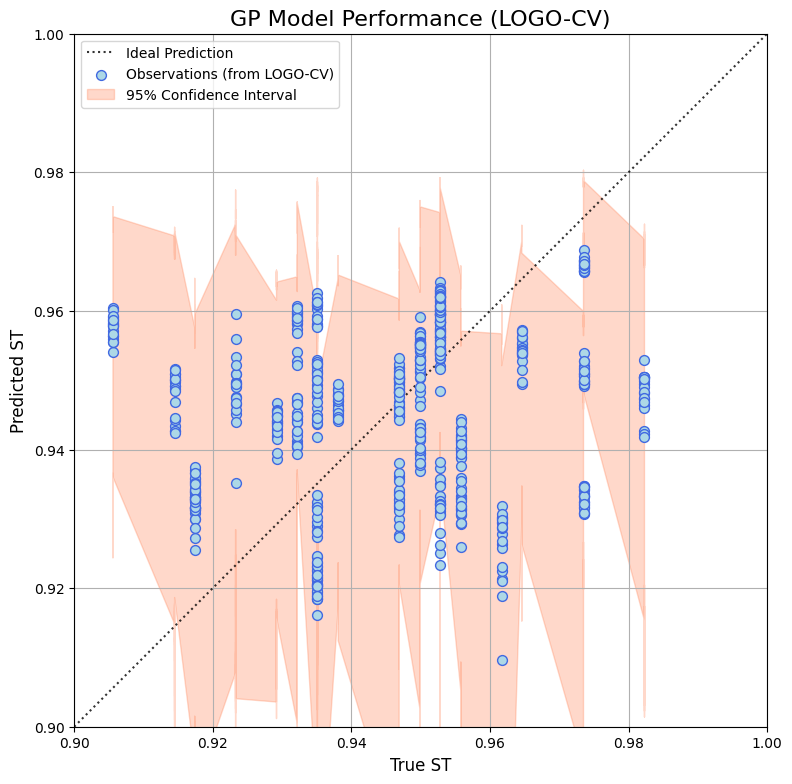

In [ ]:

df_sorted = results_df.sort('true_st')

# Calculate the 95% Confidence Interval in the original [0, 1] scale.
predicted_st_transformed = df_sorted['predicted_st_transformed'].to_numpy()
std_dev_transformed = df_sorted['prediction_std_transformed'].to_numpy()

z_score = 1.96 # for 95% confidence
upper_bound = expit(predicted_st_transformed + z_score * std_dev_transformed)
lower_bound = expit(predicted_st_transformed - z_score * std_dev_transformed)

fig, ax = plt.subplots(figsize=(9, 9))
ax.plot([0.9, 1], [0.9, 1], 'k:', alpha=0.8, label='Ideal Prediction') 
ax.scatter(df_sorted['true_st'], df_sorted['predicted_st'], 
           edgecolor='royalblue', facecolor='lightblue', s=50, zorder=3, 
           label='Observations (from LOGO-CV)')

ax.fill_between(df_sorted['true_st'], lower_bound, upper_bound, 
                color='coral', alpha=0.3, label='95% Confidence Interval')

ax.set_xlabel('True ST', fontsize=12)
ax.set_ylabel('Predicted ST', fontsize=12)
ax.set_title('GP Model Performance (LOGO-CV)', fontsize=16)
ax.legend(loc='upper left', fontsize=10)
ax.set_xlim(0.9, 1)
ax.set_ylim(0.9, 1)
ax.set_aspect('equal', 'box')
plt.grid(True)
plt.show()

## 7. Model Performance Comparison

/home/nilar/tmp/ipykernel_548789/3927854572.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


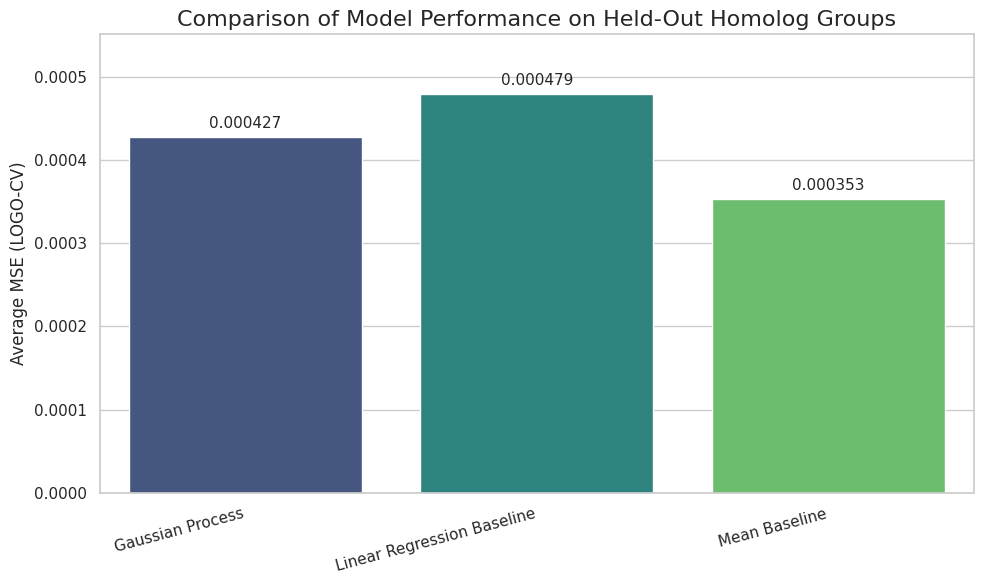

In [ ]:

model_performance = {
    'Gaussian Process': average_mse_gpjax,
    'Linear Regression Baseline': average_mse_lm,
    'Mean Baseline': average_mse_baseline
}

performance_df = pl.DataFrame({
    'Model': list(model_performance.keys()), 
    'MSE': list(model_performance.values())
})

sns.set_theme(style="whitegrid")

plt.figure(figsize=(10, 6))

ax = sns.barplot(
    data=performance_df, 
    x='Model', 
    y='MSE', 
    palette='viridis'
)

ax.set_ylabel('Average MSE (LOGO-CV)', fontsize=12)
ax.set_xlabel(None)
ax.set_title('Comparison of Model Performance on Held-Out Homolog Groups', fontsize=16)

plt.xticks(rotation=15, ha='right')

max_mse = performance_df['MSE'].max()
ax.set_ylim(0, max_mse * 1.15)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.6f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', 
                va='center', 
                fontsize=11,
                xytext=(0, 10), 
                textcoords='offset points')

plt.tight_layout()
plt.show()